Возьмите регламент по проведению государственной экологической экспертизы по ссылке https://docs.google.com/document/d/1WMp-uMA4_59Ybp2ynCvrFIPV1OwGHQA4zvW526BawJM и на его основе сделайте базу знаний для ответа на вопросы по этому регламенту с поддержанием диалога.

Напишите промпт самостоятельно.
Не забудьте установить настройки доступа на "все, у кого есть ссылка".

Создайте нейро-консультанта по данной базе знаний  с возможностью поддержания диалога. Проверьте работу созданного нейро-консультанта на самостоятельно сформулированных вопросах.

In [1]:
!pip install -q langchain_openai==0.1.22 faiss-cpu==1.8.0 openai==1.55.3 tiktoken==0.7.0 langchain-core==0.2.33 langchain==0.2.14 langchain_community==0.2.12 langchain-text-splitters==0.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00


In [2]:
# импортируем необходимые библиотеки
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
import os
import re
import requests
import openai
import tiktoken
import matplotlib.pyplot as plt
from textwrap import fill

import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)

In [3]:
from google.colab import userdata

# Использование ключа API от ProxyAPI
key = userdata.get('PROXY_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Адрес сервера ProxyAPI
base_url = 'https://api.proxyapi.ru/openai/v1'
os.environ["OPENAI_BASE_URL"] = base_url

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

In [4]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [5]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1WMp-uMA4_59Ybp2ynCvrFIPV1OwGHQA4zvW526BawJM')

In [6]:
database[:1000]

'\ufeffАдминистративный регламент\r\nФедеральной службы по надзору в сфере природопользования предоставления государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня\r\nI. Общие положения\r\n*Предмет регулирования регламента*\r\n1. Административный регламент Федеральной службы по надзору в сфере природопользования предоставления государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня (далее - Регламент) определяет сроки и последовательность административных процедур (действий) при предоставлении Федеральной службой по надзору в сфере природопользования (далее - Росприроднадзор) и ее территориальными органами государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня (далее - государственная услуга), а также порядок взаимодействия между структурными подразделениями Росприроднадзора и территориальными органами Росприроднадзора

In [7]:
# предобработаем текст таким образом, чтобы его можно было бы поделить на чанки при помощи MarkdownHeaderTextSplitter
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    '''Далее используем функцию re.sub из модуля регулярных выражений re для замены подстрок в строке text.
    Шаблон регулярного выражения (I{1,3}|IV|V)\. (.+) ищет римские числа от I до V в начале строки, за которыми следует точка и пробел.
    Функция replace_header1 вызывается для каждого совпадения, и ее возвращаемое значение используется для замены найденной подстроки.
    Флаг re.M позволяет ^ соответствовать началу каждой строки, а не только началу всего текста.'''
    text = re.sub(r'^(I{1,3}|IV|V)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [8]:
markdown = text_to_markdown(database)                 # заполните необходимым значением
print(markdown[:15000])

﻿Административный регламент
Федеральной службы по надзору в сфере природопользования предоставления государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня
# Общие положения
Общие положения
## Предмет регулирования регламента
Предмет регулирования регламента
1. Административный регламент Федеральной службы по надзору в сфере природопользования предоставления государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня (далее - Регламент) определяет сроки и последовательность административных процедур (действий) при предоставлении Федеральной службой по надзору в сфере природопользования (далее - Росприроднадзор) и ее территориальными органами государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня (далее - государственная услуга), а также порядок взаимодействия между структурными подразделениями Росприроднадзора и территориал

In [9]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1o5ODxDrCt42EOnjbNUZMD-BW0Mb_qP9Gbg_RQLQmwxs/edit?usp=sharing')

In [10]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks

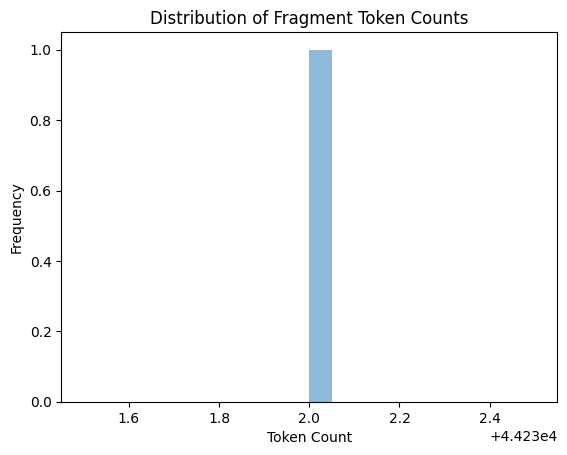

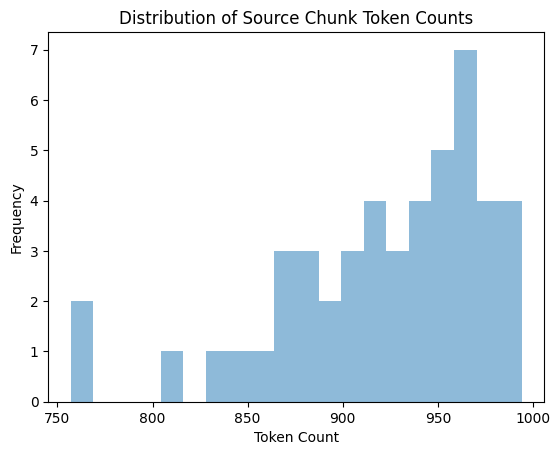

Общее количество чанков:  48
Первый чанк  page_content='Административный регламент
Федеральной службы по надзору в сфере природопользования предоставления государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня
I. Общие положения
*Предмет регулирования регламента*
1. Административный регламент Федеральной службы по надзору в сфере природопользования предоставления государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня (далее - Регламент) определяет сроки и последовательность административных процедур (действий) при предоставлении Федеральной службой по надзору в сфере природопользования (далее - Росприроднадзор) и ее территориальными органами государственной услуги по организации и проведению государственной экологической экспертизы федерального уровня (далее - государственная услуга), а также порядок взаимодействия между структурными подразделениями Росприроднадзора и терри

In [18]:
source_chunks = split_text(database, 1000)                          # заполните необходимыми значениями
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [20]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)                            # заполните необходимыми значениями

In [21]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [22]:
def answer_index(system, search_query, topic, search_index, verbose=0):
    # Поиск релевантных отрезков из базы знаний по вопросу пользователя
    docs = search_index.similarity_search(search_query, k=3)
    if verbose:
        print('\n ===========================================: ')

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose:
        print('message_content :\n ======================================== \n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос пользователя. Документы с информацией для ответа клиенту: {message_content}\n\n{topic}"}
    ]

    if verbose:
        print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini",                                      # заполните необходимыми значениями
        messages=messages,
        temperature=0.2                                   # заполните необходимыми значениями
    )
    answer = completion.choices[0].message.content
    return answer


In [27]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-4o-mini",      # заполните необходимыми значениями
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

In [24]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " +summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ, используя только user_question для поиска в базе данных
    answer_text = answer_index(system, user_question, topic, db)

    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    return answer_text


In [29]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', insert_newlines(answer))

    return

In [30]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db)

Пользователь: кто является заявителем при предоставлении государственной услуги
Консультант:  Заявителем при предоставлении государственной услуги по организации и проведению государственной экологической экспертизы могут быть различные лица в зависимости от типа
 объектов. Это могут быть: 1. Лица, наделенные правами и обязанностями по разработке проектов нормативно-технических и инструктивно-методических документов в области
 охраны окружающей среды, а также проекты федеральных целевых программ, которые касаются строительства и эксплуатации объектов, оказывающих воздействие на окружающую
 среду. 2. Соискатели лицензии или лицензии, если речь идет о деятельности в области использования атомной энергии. 3. Юридические лица или индивидуальные
 предприниматели, которые являются заказчиками по подготовке проекта технической документации и представляют ее на экологическую экспертизу. Таким образом, заявителем
 может быть как физическое, так и юридическое лицо, в зависимости от конкретной си